# ML-7. Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

In [85]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import (linear_model,
                     tree,
                     ensemble, 
                     metrics,
                     preprocessing, 
                     model_selection)
import warnings

In [86]:
%matplotlib inline
warnings.filterwarnings('ignore')

### Описание задачи

Продолжим решать задачу кассификации из модуля ML-3: "Предсказание категории дохода человека"

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


### Знакомство с данными и их исследование

In [87]:
#ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.csv')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [88]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [89]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

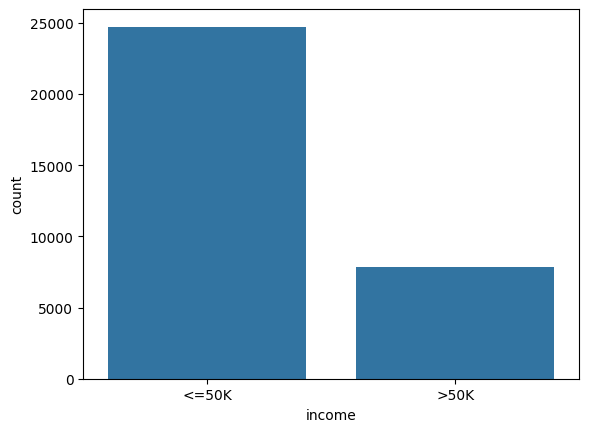

In [90]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [91]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [92]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

In [93]:
data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0


### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [94]:
adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [95]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [96]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [97]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

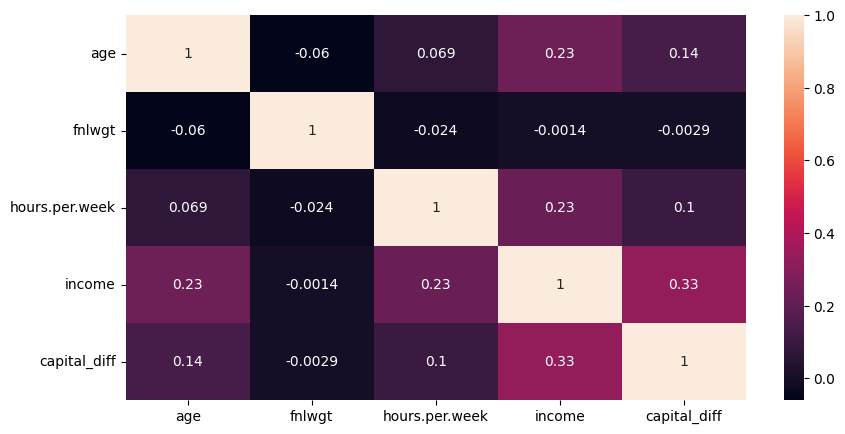

In [98]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(numeric_only=True), annot = True);

Кодируем текстовые категориальные признаки

In [99]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
1,82,11.797134,18,0,8.379539,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
2,66,12.133835,40,0,8.379539,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,True
3,54,11.851966,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
4,41,12.486216,40,0,8.268988,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [100]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [101]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [102]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [103]:
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy: 0.84
F1: 0.64


### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 
- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.


In [104]:
param_grid = {'penalty' : ['l2', 'none'],
              'solver' : ['lbfgs', 'saga']}

grid_search = model_selection.GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

{'penalty': 'l2', 'solver': 'saga'}


In [107]:
print('Accuracy: {:.2f}'.format(grid_search.score(y= y_test, X=X_test_scaled,)))

Accuracy: 0.84


In [108]:
y_test_pred = grid_search.predict(X_test_scaled)
print('F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1: 0.64


Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться.

**Попробуем расширить сетку гиперпараметров.**

In [110]:
param_grid_1 = [
    {'penalty' : ['l2', 'none'],
     'solver' : ['lbfgs', 'saga'],
     'C' : [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
    
    {'penalty' : ['l2', 'l1'],
     'solver' : ['liblinear', 'saga'],
     'C' : [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_1 = model_selection.GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_1,
    cv=5,
    n_jobs=-1
)
%time grid_search_1.fit(X_train_scaled, y_train)
print('Accuracy : {:.2f}'.format(grid_search_1.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(grid_search_1.best_params_)

CPU times: total: 1.14 s
Wall time: 12.9 s
Accuracy : 0.84
F1: 0.64
{'C': 0.9, 'penalty': 'l2', 'solver': 'lbfgs'}


**Метрику опять не удалось улучшить, а время потратили много, в 5 раз больше!**

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.


Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [111]:
print(grid_search_1.best_estimator_)

LogisticRegression(C=0.9, max_iter=1000, random_state=1)


In [112]:
print(grid_search_1.best_score_)

0.8432894418305243


In [123]:
cv_result_df = pd.DataFrame(grid_search_1.cv_results_)
visual = pd.pivot_table(
    data=cv_result_df,
    values='mean_test_score',
    index='param_C',
    columns='param_solver'
)
visual

param_solver,lbfgs,liblinear,saga
param_C,,,
0.01,0.837300,0.832694,0.834447
0.10,0.842138,0.841677,0.841984
0.30,0.842906,0.842426,0.843110
0.50,0.843251,0.842982,0.843174
0.70,0.843097,0.843097,0.843136
0.90,0.843289,0.842963,0.843136
1.00,0.843021,0.842925,0.843046


<Axes: xlabel='param_solver', ylabel='param_C'>

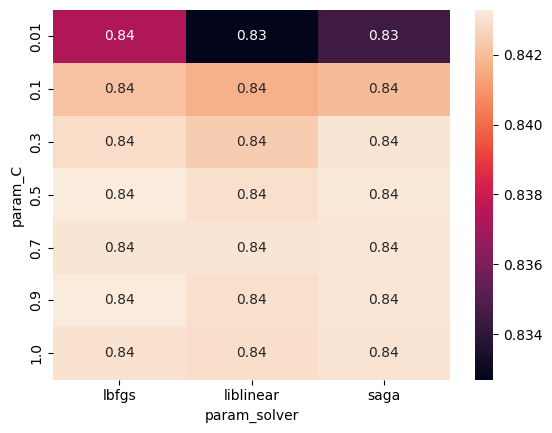

In [124]:
sns.heatmap(visual, annot=True)

А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_. 

**не путайте best_score_ со значением точности модели, которое вычисляется на тестовом наборе с помощью метода score. Метод score (оценивающий качество результатов, полученных с помощью метода predict) использует модель, построенную на всем обучающем наборе данных. В атрибуте best_score_ записывается средняя точность кросс-валидации. Для ее вычисления используется модель, построенная на обучающем наборе кросс-валидации.

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,5 и  алгоритмы оптимизации lbfgs и sag работают лучше.

### <center> **RandomizedSearchCV**

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

In [125]:
param_distributions = {
    'penalty' : ['l2', 'none'],
    'solver' : ['lbfgs', 'sag'],
    'C' : list(np.linspace(0.01, 1, 10, dtype=float))
}
model = linear_model.LogisticRegression(max_iter=1000, random_state=42)
random_search = model_selection.RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    cv=5,
    n_jobs=-1,
    n_iter=10
)
%time random_search.fit(X_train_scaled, y_train)
print('Accuracy: {:.2f}'.format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(random_search.best_params_)

CPU times: total: 109 ms
Wall time: 3.64 s
Accuracy: 0.84
f1: 0.64
{'solver': 'sag', 'penalty': 'l2', 'C': 0.45}


#### **Дерево решений**

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [127]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
print('Accuracy train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('F1 train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Accuracy test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('F1 test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy train: 1.00
F1 train: 1.00
Accuracy test: 0.81
F1 test: 0.62


Теперь зададим сетку гиперпараметров:  
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
*  'criterion' - критерий информативности

И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [128]:
param_distributions_1 = {
    'min_samples_leaf' : list(np.linspace(5, 100, 50, dtype=int)),
    'max_depth' : list(np.linspace(1, 30, 50, dtype=int)),
    'criterion' : ['entropy', 'gini']
}

In [130]:
random_search_tree = model_selection.RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_distributions_1,
    cv=5,
    n_jobs=-1,
    n_iter=50
)
%time random_search_tree.fit(X_train_scaled, y_train)
print('Accuracy: {:.2f}'.format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(random_search_tree.best_params_)

CPU times: total: 969 ms
Wall time: 4.19 s
Accuracy: 0.85
f1: 0.66
{'min_samples_leaf': 39, 'max_depth': 16, 'criterion': 'gini'}


Метрику удалось улучшить  с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени;

#### **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [131]:
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
print('Accuracy train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('F1 train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Accuracy test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('F1 test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy train: 1.00
F1 train: 1.00
Accuracy test: 0.85
F1 test: 0.66


Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100

*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;




И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [132]:
param_distributions_2 = {
    'n_estimators' : list(range(80, 200, 30)),
    'min_samples_leaf' : [5],
    'max_depth' : list(np.linspace(20, 40, 10, dtype=int))  
}

In [150]:
random_search_rf = model_selection.RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions_2,
    cv=5,
    # n_jobs=-1,
    n_iter=50
)
%time random_search_rf.fit(X_train_scaled, y_train)
print('Accuracy: {:.2f}'.format(random_search_rf.score(X_test_scaled, y_test)))
y_test_pred = random_search_rf.predict(X_test_scaled)
print('f1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(random_search_rf.best_params_)

CPU times: total: 42.6 s
Wall time: 4min 51s
Accuracy: 0.86
f1: 0.67
{'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 28}


Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось в два раза меньше времени;

#### **Вывод по базовой оптимизации:**
На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

### <center> Hyperopt

In [ ]:
# Устанавливаем библиотеку
# !pip install hyperopt
# или
#!conda install -c conda-forge hyperopt

In [139]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [140]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [141]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [149]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [01:49<00:00,  2.20s/trial, best loss: -0.7991158267020336]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 104.0}
CPU times: total: 20.9 s
Wall time: 1min 49s


In [145]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.75
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты.

In [147]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 23/23 [00:06<00:00,  2.15s/trial, best loss: -0.7784334763948498]
Наилучшие значения гиперпараметров {'max_depth': 21.0, 'min_samples_leaf': 2.0, 'n_estimators': 101.0}


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

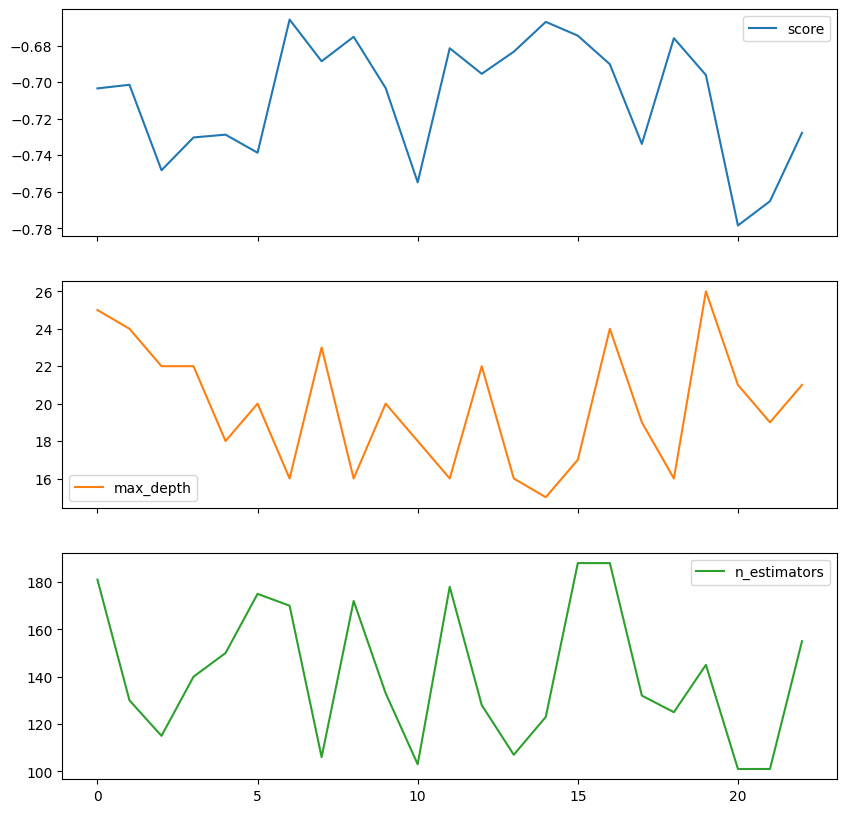

In [148]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

По графикам видно, что лучшая точность достигается именно в best_params. Но заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как,  hyperopt может только минимизировать.

## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [ ]:
# Устанавливаем библиотеку
# !pip install optuna
# или
#!conda install -c conda-forge optuna

In [151]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.6.1


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [152]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  
  

In [153]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2024-08-09 15:11:29,279] A new study created in memory with name: RandomForestClassifier
[I 2024-08-09 15:11:31,203] Trial 0 finished with value: 0.7338051170386499 and parameters: {'n_estimators': 100, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7338051170386499.
[I 2024-08-09 15:11:33,771] Trial 1 finished with value: 0.6752519596864501 and parameters: {'n_estimators': 165, 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7338051170386499.
[I 2024-08-09 15:11:35,267] Trial 2 finished with value: 0.6486123115336598 and parameters: {'n_estimators': 113, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7338051170386499.
[I 2024-08-09 15:11:38,583] Trial 3 finished with value: 0.7237544081743377 and parameters: {'n_estimators': 192, 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7338051170386499.
[I 2024-08-09 15:11:40,512] Trial 4 finished with value: 0.6600947867298578 and parameters: {'n_

CPU times: total: 25.7 s
Wall time: 2min 6s


In [154]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 140, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [155]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68


In [156]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2024-08-09 15:15:09,892] Trial 50 finished with value: 0.7583184257602862 and parameters: {'n_estimators': 168, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 38 with value: 0.8217040673211781.
[I 2024-08-09 15:15:13,237] Trial 51 finished with value: 0.8220450363620433 and parameters: {'n_estimators': 173, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 51 with value: 0.8220450363620433.
[I 2024-08-09 15:15:16,612] Trial 52 finished with value: 0.8223234624145785 and parameters: {'n_estimators': 171, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 52 with value: 0.8223234624145785.
[I 2024-08-09 15:15:20,002] Trial 53 finished with value: 0.8220450363620433 and parameters: {'n_estimators': 173, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 52 with value: 0.8223234624145785.
[I 2024-08-09 15:15:23,449] Trial 54 finished with value: 0.8221793973370708 and parameters: {'n_estimators': 176, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 52 with va

CPU times: total: 8.7 s
Wall time: 34.1 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [157]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [158]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [159]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [160]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с синим фоном это и есть лучшии комбинации n_estimator, max_depth.














